In [1]:
import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 
sys.path.insert(0, currentdir + "\Code") 

In [2]:
import math
import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
from scipy.integrate import odeint, DOP853, solve_ivp
from itertools import chain, combinations, permutations

from ring_functions import *

cmap = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## Helper functions

In [3]:
# # symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# # where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# # For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# # The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# # (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

# def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
#     # W sym jk = JI + JE cos(theta_j - theta_K)
#     x = np.arange(0,N,1)
#     row = J_I + J_E*np.cos(2*np.pi*x/N)
#     W = scipy.linalg.circulant(row)
#     return W


# # W asym jk =sin(theta_j - theta_k)
# def get_noorman_asymmetric_weights(N):
#     # W asym jk =sin(theta_j - theta_k)
#     x = np.arange(0,N,1)
#     row = np.sin(2*np.pi*x/N)
#     W = scipy.linalg.circulant(row)
#     return W

# def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N):
#     """Differential equation of head direction network in Noorman et al., 2022. 
#     tau: integration constant
#     transfer_function: each neuron transforms its inputs via a nonlinear transfer function
#     W_sym, W_asym: symmetric and asymmetric weight matrices
#     v_in: input
#     c_ff: a constant feedforward input to all neurons in the network
#     N: number of neurons in the network
#     """

#     return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

# #Bump perturbations
# def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
#     """
#     create ODE for Noorman ring attractor with a local bump perturbation
#     center,rotation_mat,amplitude,b are set
#     """
#     vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
#     noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
#     return noor + vector_bump

# def noorman_ode_Npert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,Nbumps):
#     """
#     create ODE for Noorman ring attractor with Nbumps local bump perturbations
#     for each bump: center,rotation_mat,amplitude,b are random
#     """
#     noorode = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
#     for bi in range(Nbumps):
#         bump_i = np.random.randint(bumps.shape[0]) 
#         roll_j = np.random.randint(N)
#         center = np.roll(bumps[:,bump_i], roll_j).copy()
#         rotation_mat = special_ortho_group.rvs(N)
#         amplitude = np.random.rand()
#         b = np.random.rand()
#         noorode += bump_perturbation(x, center, rotation_mat, amplitude, b)

#     return noorode

# # Fixed points and their stabilities
# def noorman_jacobian(x, W_sym):
#     N = W_sym.shape[0]
    
#     r = np.where(x>0)
#     W_sub = np.zeros((N,N))
#     W_sub[:,r] = W_sym[:,r]
#     J = -np.eye(N)
#     J += W_sub/N
#     return J

# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# def noorman_fixed_points(W_sym, c_ff):
#     """
#     Takes as argument all the parameters of the recurrent part of the model (W_sym, c_ff)
#     \dot x = -x + 1/N W_sym ReLU(x) + c_ff = 0
#     """
#     fixed_point_list = []

#     N = W_sym.shape[0]
#     subsets = powerset(range(N))
#     for support in subsets:
#         if support == ():
#             continue
#         r = np.array(support)
        
#         W_sub = np.zeros((N,N))
#         W_sub[:,r] = W_sym[:,r]
#         A = W_sub/N - np.eye(N)
#         fixed_point = -np.dot(np.linalg.inv(A), np.ones(N)*c_ff)
        
#         #check true fixed point
#         negativity_condition = True
#         # print(r, [item for item in range(N) if item not in r])
#         for i in r:
#             if fixed_point[i] <= 0:
#                 negativity_condition = False
#         for i in [item for item in range(N) if item not in r]:
#             if fixed_point[i] >= 0:
#                 negativity_condition = False
        
#         if negativity_condition:
#             fixed_point_list.append(fixed_point)
        
#     fixed_point_array = np.array(fixed_point_list)
#     return fixed_point_array




# def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
#     """
#     Perturbation is composed of parallel vector field 
#     with the location given by center, 
#     the norm of the vectors determined by a bump function
#     and the orientation given by theta
    
#     x.shape = (Numberofpoints,N)
#     rotation_mat: orientation of perturbation
#     implemented for N-dimensional systems
#     """
#     N = x.shape[0]
#     vector_bump = np.zeros(N)
#     vector_bump[0] = 1.
#     rotation_mat = special_ortho_group.rvs(N)
#     vector_bump = np.dot(vector_bump, rotation_mat)
#     vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
#     return vector_bump

# # we will take phi(·) to be threshold linear

# def v_in(t):
#     return 0



In [4]:
# # circle_in_vectorspace = 

# # #create points on hypersphere as:
# # 1. take p=[1, 0, ... 0]
# # 2. rotate point(s) along next axis ????

# def fibonacci_sphere(samples=1000):

#     points = []
#     phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

#     for i in range(samples):
#         y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
#         radius = math.sqrt(1 - y * y)  # radius at y

#         theta = phi * i  # golden angle increment

#         x = math.cos(theta) * radius
#         z = math.sin(theta) * radius

#         points.append((x, y, z))

#     return points

def hypersphere_lattice(n_points, n_dim):
    """
    Generate a lattice of points on an N-dimensional hypersphere.
    """
    points = np.random.uniform(-1, 1, size=(n_points, n_dim))
    norms = np.linalg.norm(points, axis=1)
    normalized_points = points / norms[:, np.newaxis]
    return normalized_points

def uniform_hypersphere_points(n_points, n_dim):
    """
    Generate a lattice of points on an N-dimensional hypersphere.
    """
    points = np.zeros((n_points, n_dim))
    for i in range(n_points):
        vec_0 = np.zeros((n_dim))
        vec_0[0] = 1
        points[i, :] = np.dot(special_ortho_group.rvs(n_dim), vec_0)

    return points

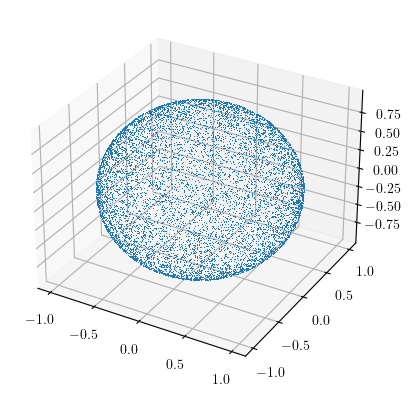

In [5]:
n_points = 10000
n_dim = 3
circle = uniform_hypersphere_points(n_points, n_dim)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(circle[:,0], circle[:,1], circle[:,2], ',')

### Define model and plot one trajectory

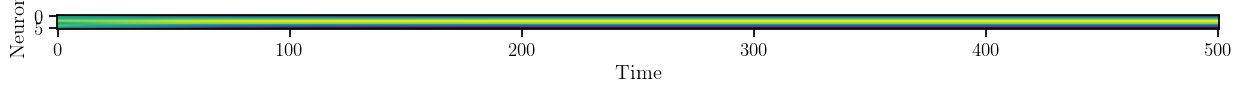

In [23]:
np.random.seed(1331)

tau = 1
transfer_function = ReLU
N = 6
J_I = -2.4
J_E = 4
W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
W_asym = get_noorman_asymmetric_weights(N)
c_ff = 1.

maxT = 25
t = np.linspace(0, maxT, 501)
y0 = np.random.uniform(0,1,N)

sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharex=True, sharey=True)
axs.imshow(sol.sol(t))
axs.set_xlabel("Time")
axs.set_ylabel("Neurons");

#### Bump activity (final state of trajectory)

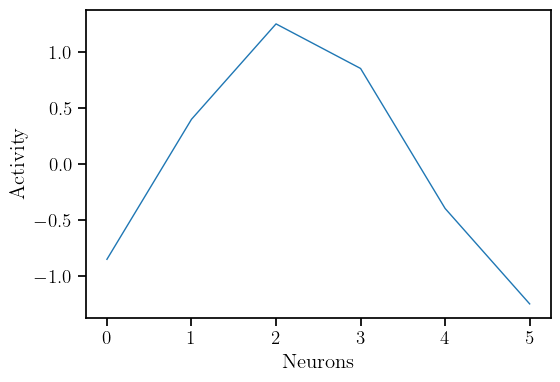

In [24]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(sol.sol(t)[:,-1])
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

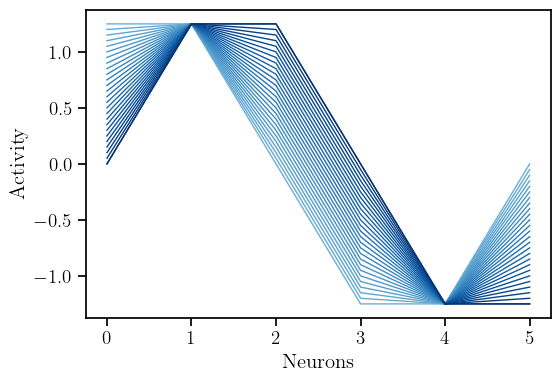

In [29]:
m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
if N==4:
    m = 1.6666667980972478
elif N==8:
    m = 1.38
    # m = 0.8036227284520995


corners = get_corners(N, m)
bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
step_size = .1
x = np.arange(0, m+step_size, step_size)
all_bumps = get_all_bumps(N, bumps)

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
colors = plt.cm.Blues(np.linspace(0.5,1,bumps.shape[1]+1))
ax.set_prop_cycle('color', colors)
for bump_i in range(bumps.shape[1]):
    ax.plot(bumps[:,bump_i])
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

##### Integrate from all a lattice of positions along the ring attractor

In [30]:
maxT = 200
t = np.linspace(0, maxT, 501)

sols = np.zeros((bumps.shape[1], N, t.shape[0], N))
for bump_i in range(bumps.shape[1]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T

In [31]:
# m = np.max(sols[:,:,-1,:])
# m = .92

##### Plot final states in pc space

In [32]:
if N==8:
    step_size = .001
    x = np.arange(0, m+step_size, step_size)
    bumps = np.array([m-x/2.,m*np.ones(x.shape),(m+x)/2.,-m/2.+x,-m+x/2.,-m*np.ones(x.shape),-(m+x)/2.,m/2.-x])

    corners = []
    for support_j in range(N):
        corners.append(np.roll(bumps[:,0], support_j))
    # corners = np.array(corners).T
    # bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.01)
    # all_bumps = get_all_bumps(N, bumps)

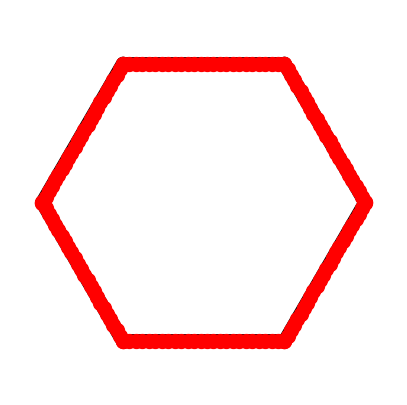

In [33]:
N_points = bumps.shape[0]*bumps.shape[1]
sols = sols.reshape((-1, t.shape[0], N))
pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.fit_transform(sols[:,-1,:]) 
all_bumps_proj2 = pca.fit_transform(all_bumps) 
corners_proj2 = pca.transform(corners)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'k', label="Original attractor", zorder=0, alpha=1., linewidth=10, 
            solid_capstyle='round')
    
ax.plot(X_proj2[:,0], X_proj2[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20)

lims = 3.
ax.set(xlim=(-lims, lims), ylim=(-lims,lims))

ax.set_axis_off()
# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}.pdf", bbox_inches="tight")

In [133]:
383+35

418

### Perturbations

In [107]:
#To all connections
np.random.seed(25862)

seeds = [33, 27, 0, 3, 13, 418, 1550]
# N=6: np.random.uniform(-1,1,(N,N))/100.
#     np.random.seed(33)->0/0
#     np.random.seed(27)->1/1
#     np.random.seed(0)->2/2
#     np.random.seed(3)->3/3
#     np.random.seed(13)->4/4
#     np.random.seed(383+35)->5/5
#     np.random.seed(1550)->6/6

# N=8
# 0, 2, 1, 3, 55, 35, 3748, 25862

eps = np.random.uniform(-1,1,(N,N))
eps /= np.linalg.norm(eps)
norm = .5
eps *= norm
print(np.linalg.norm(eps))
#To a single connection
#non-self
# eps = np.zeros((N,N))
# eps[0,1] = 1/100.

# ## Self
# eps = np.zeros((N,N))
# eps[0,0] = 1/100.

0.49999999999999994


In [144]:
# np.savetxt("eps_N4_0stab_0sadd.csv", eps, delimiter=",")

def plot_ring_and_fixedpoints(W_sym, eps, c_ff, ax=None,  markersize=20):
    fixed_points = noorman_fixed_points(W_sym+eps, c_ff)
    fixed_points_proj2 = pca.transform(fixed_points) 

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    n_stab=0
    n_sadd=0
    for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
        fixed_point = fixed_points[f_i]
        eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
        if np.all(np.real(eigenvalues)<0):
            ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize= markersize)
            n_stab+=1
        else:
            ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize= markersize)
            n_sadd+=1

    for i in range(N):
        ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
                [corners_proj2[i-1,1], corners_proj2[i,1]],
                'k', label="Original attractor", zorder=0, alpha=1., linewidth=10, 
                solid_capstyle='round')

    ax.set(xlim=(-lims, lims), ylim=(-lims,lims))
    ax.set_xticks([])
    ax.set_yticks([])
    original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                              markersize=1, label="Original attractor")
    stable = mlines.Line2D([], [], color='g', marker='.', linestyle='None',
                              markersize=5, label="Stable")
    ax.set_axis_off()
    if not ax:
        plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_{n_stab}stab_{n_sadd-1}sadd_norm{norm}.pdf", bbox_inches="tight")
        plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_{n_stab}stab_{n_sadd-1}sadd_norm{norm}.png", bbox_inches="tight")


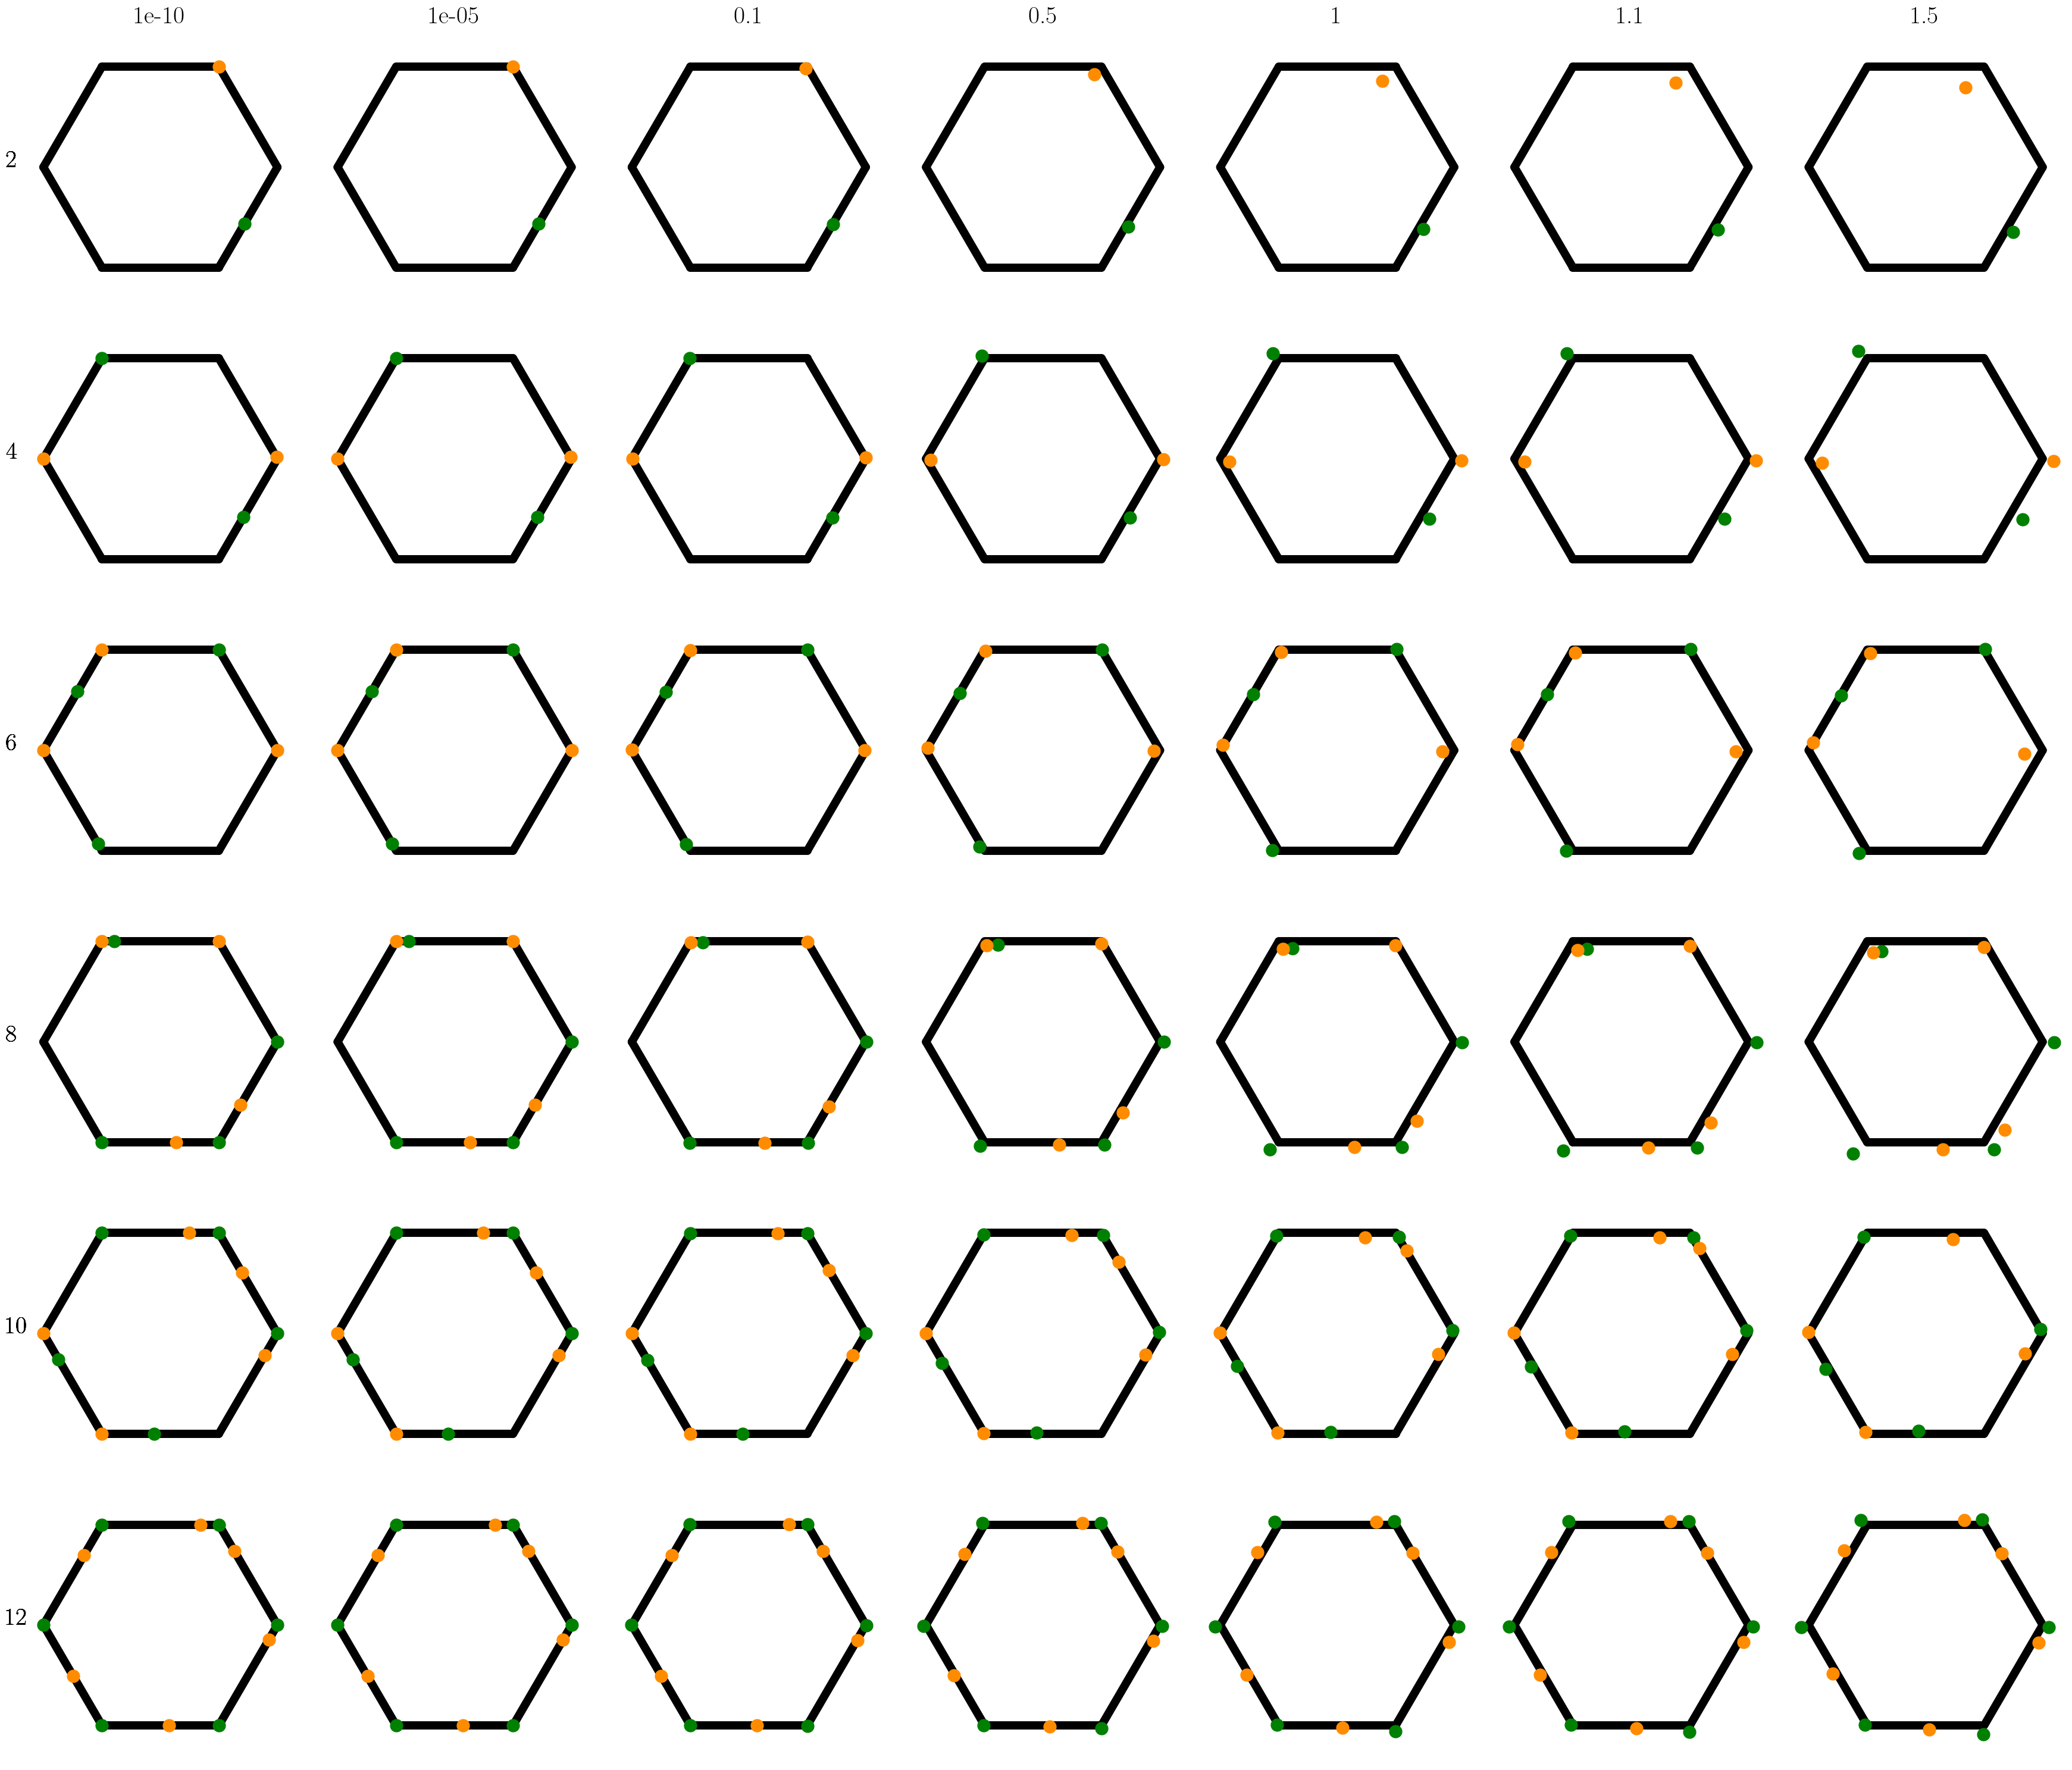

In [151]:
seeds = [27, 0, 3, 13, 418, 1550] #33->0
norms =  [1e-10, 1e-5, 1e-1, .5, 1, 1.1, 1.5]

fig, axes = plt.subplots(len(seeds), len(norms), figsize=(5*len(norms), 5*len(seeds)))
for si, seed in enumerate(seeds):
    for ni, norm in enumerate(norms):
        ax = axes[0,ni]
        ax.set_title(norm, fontsize=30)
        ax = axes[si,0]
        ax.text(x=-1.1*lims, y=0, s=2*(si+1), fontsize=30)

        ax = axes[si,ni]
        np.random.seed(seed)
        eps = np.random.uniform(-1,1,(N,N))
        eps /= np.linalg.norm(eps)
        eps *= norm
        plot_ring_and_fixedpoints(W_sym, eps, c_ff, ax,  markersize=30)
plt.tight_layout()
plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_allfxdpnts_allnorms.pdf", bbox_inches="tight")

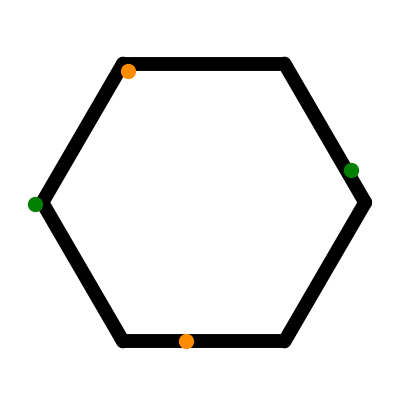

In [109]:
# eps = np.random.uniform(-1,1,(N,N))/1000.
fixed_points = noorman_fixed_points(W_sym+eps, c_ff)
fixed_points_proj2 = pca.transform(fixed_points) 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
n_stab=0
n_sadd=0
for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
        n_stab+=1
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)
        n_sadd+=1

for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'k', label="Original attractor", zorder=0, alpha=1., linewidth=10, 
            solid_capstyle='round')

ax.set(xlim=(-lims, lims), ylim=(-lims,lims))
ax.set_xticks([])
ax.set_yticks([])
original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                          markersize=1, label="Original attractor")
stable = mlines.Line2D([], [], color='g', marker='.', linestyle='None',
                          markersize=5, label="Stable")
ax.set_axis_off()
plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_{n_stab}stab_{n_sadd-1}sadd_norm{norm}.pdf", bbox_inches="tight")
plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_{n_stab}stab_{n_sadd-1}sadd_norm{norm}.png", bbox_inches="tight")
# plt.show()

##### Finding neighbours along ring attractor

### Finding connecting orbits

In [228]:
bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
all_bumps = get_all_bumps(N, bumps)

N_fixed_points = fixed_points.shape[0]
maxT = 1e5
t = np.linspace(0, maxT, 501)
tau = 1
n_perts = 3
sols = np.zeros((N_fixed_points-1, n_perts, t.shape[0], N))
for f_i, fixed_point in tqdm(enumerate(fixed_points[:-1])):
    dist_to_all_bumps = scipy.spatial.distance.cdist(all_bumps,fixed_point.reshape((1,-1)))
    ordered_bumps = all_bumps[np.argsort(dist_to_all_bumps, axis=0)].squeeze()
    for i in range(n_perts):
        y0 = ordered_bumps[i]
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]), dense_output=True)
        sols[f_i,i,...] = sol.sol(t).T

14it [16:48, 72.00s/it]


In [229]:
# y0 = ordered_bumps[5]
# sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]), dense_output=True)
# sols[np.arange(501), :] = sol.sol(t).T

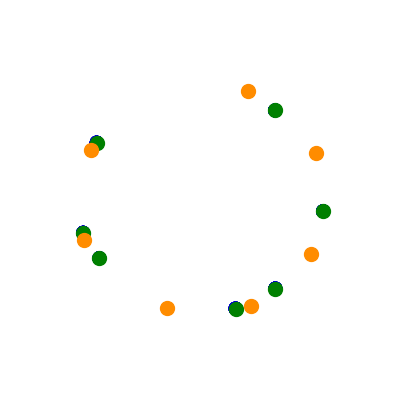

In [230]:
sols = sols.reshape(((N_fixed_points-1)*n_perts*sol.sol(t).shape[1], N))
X_proj2 = pca.transform(sols[:,:]) 
X_proj2_pertraj = X_proj2.reshape(((N_fixed_points-1)*n_perts, sol.sol(t).shape[1], 2))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.plot(X_proj2[:,0], X_proj2[:,1], '.k', label="", alpha=1., markersize=10, zorder=99)
for traj_i in range((N_fixed_points-1)*n_perts):
    traj = X_proj2_pertraj[traj_i]
    ax.plot(traj[2:,0], traj[2:,1], color='mediumblue', label="", alpha=1., linewidth=10, zorder=99, solid_capstyle='round')

n_stab = 0
n_sadd = 0
for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
        n_stab+=1
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)
        n_sadd+=1

ax.set(xlim=(-lims, lims), ylim=(-lims, lims))
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_connorbs_{n_stab}stab_{n_sadd}sadd.pdf", bbox_inches="tight")
# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_pert_connorbs_{n_stab}stab_{n_sadd}sadd.png", bbox_inches="tight")

#### Eigenvalues of Jacobian

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_prop_cycle(color=['k', 'crimson', 'b', 'orange', 'g'])
ax.set_prop_cycle(marker=['o', 'x'])

colors = ['g', 'r']

for f_i, fixed_point in enumerate(fixed_points):
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    # ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i)
    if np.all(np.real(eigenvalues)<0):
        ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i, color=colors[0])
    else:
        ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i, color=colors[1])

#### Distribution of topologies

In [209]:
number_of_fixed_points = []
number_of_stable_fixed_points = []

pert_size = 1e-2
distribution_of_pert = 'cube'
for i in tqdm(range(0,100000)):
    #uniform in hypercube
    np.random.seed(i)
    if distribution_of_pert=='cube':
        eps = pert_size*np.random.uniform(-1,1,(N,N))
    
    #uniform in hypersphere
    elif distribution_of_pert== 'ball':
        vector_pert = np.zeros(N**2)
        vector_pert[0] = 1.
        rotation_mat = special_ortho_group.rvs(N**2)
        eps = pert_size*np.dot(vector_pert, rotation_mat).reshape((N,N))
    
    elif distribution_of_pert == 'rankone':
        eps = np.random.uniform(-1,1,(N,2))
        eps = pert_size*np.outer(eps[:,0], eps[:,1]).reshape((N,N))

    fixed_points = noorman_fixed_points(W_sym+eps, c_ff)
    # if fixed_points.shape[0]==13:
    #     break
    if fixed_points.shape[0]==17:
        break
    number_stabs = 0
    for f_i, fixed_point_p in enumerate(fixed_points):
        fixed_point = fixed_points[f_i]
        eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
        if np.all(np.real(eigenvalues)<0):
            number_stabs += 1
    number_of_stable_fixed_points.append(number_stabs)
    number_of_fixed_points.append(fixed_points.shape[0]-1)

 26%|██████████████████▉                                                      | 25862/100000 [57:02<2:43:31,  7.56it/s]


In [ ]:
np.unique(number_of_fixed_points)


In [ ]:
weights = np.ones_like(number_of_fixed_points)/float(len(number_of_fixed_points))

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)

ax.set_ylabel("Proportion")
ax.set_xlabel("Number of fixed points");
hist = ax.hist(number_of_fixed_points, bins=np.arange(-.5, 12.6, 1), weights=weights);
ax.set_xticks(np.arange(0, 14, 2))
ax.set_xlim([1,13])
# ax.set_xticklabels(np.arange(-2, 14, 1))

plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_{distribution_of_pert}_{pert_size}_nfp_histogram.png", bbox_inches="tight")
plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_{distribution_of_pert}_{pert_size}_nfp_histogram.pdf", bbox_inches="tight")

In [ ]:
hist

In [1018]:
# weights = np.ones_like(number_of_stable_fixed_points)/float(len(number_of_stable_fixed_points))

# sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
# fig = plt.figure(figsize=(6,4))
# ax = plt.subplot(111)

# ax.set_ylabel("Proportion")
# ax.set_xlabel("Number of stable fixed points");
# ax.hist(number_of_stable_fixed_points, bins=np.arange(-.5, 5.5, 1), weights=weights);

# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_spherepert{pert_size}_nfpstab_histogram.png", bbox_inches="tight")
# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}_spherepert{pert_size}_nfpstab_histogram.pdf", bbox_inches="tight")

In [1019]:
np.array(number_of_fixed_points)[np.where(0.5!=np.array(number_of_stable_fixed_points)/np.array(number_of_fixed_points))]

C:\Users\abel_\AppData\Local\Temp\ipykernel_13868\4199325028.py:1: RuntimeWarning: invalid value encountered in divide
  np.array(number_of_fixed_points)[np.where(0.5!=np.array(number_of_stable_fixed_points)/np.array(number_of_fixed_points))]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Long trajectories

In [1339]:
bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.01)
all_bumps = get_all_bumps(N, bumps)

maxT = 2*20
t = np.linspace(0, maxT, 2*5001)

epssols = np.zeros((bumps.shape[1], N, t.shape[0], N))
for bump_i in range(bumps.shape[1]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T
        

<Figure size 500x500 with 0 Axes>

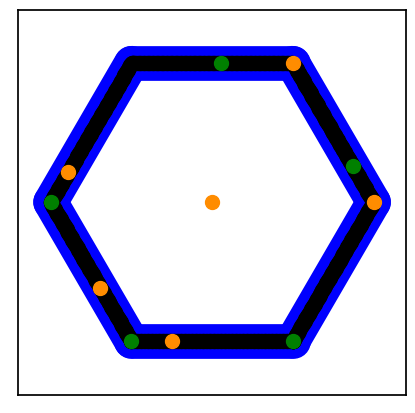

In [1343]:
N_points = bumps.shape[0]*bumps.shape[1]
epssols_flat = epssols.reshape((-1, t.shape[0], N))
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:]) 
Xeps_start_proj2 = pca.transform(epssols_flat[:,40,:]) 
corners_proj2 = pca.transform(corners)
fixed_points_proj2 = pca.transform(fixed_points) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
# ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=20)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.k', label="Stable", zorder=10, alpha=1., markersize=20)
# for i in range(1000):
#     Xeps_start_proj2 = pca.transform(epssols_flat[:,i*1,:]) 
    # ax.plot(Xeps_start_proj2[:,0], Xeps_start_proj2[:,1], '.g', zorder=9, alpha=1., markersize=9)
for f_i, fixed_point_p in enumerate(fixed_points_proj2):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)

# ax.plot(fixed_points_proj2[:,0], fixed_points_proj2[:,1], '.k', label="Analytical", zorder=99, alpha=1., markersize=9)
# for f_i, fixed_point in enumerate(fixed_points_proj2):
#     ax.text(fixed_point[0]*1.2, fixed_point[1]*1.2, str(f_i), color="black", fontsize=12)

for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'b', label="Original attractor", zorder=0, alpha=1., linewidth=25, 
            solid_capstyle='round')

ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
          # fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                          markersize=1, label="Original attractor")
stable = mlines.Line2D([], [], color='r', marker='.', linestyle='None',
                          markersize=5, label="Stable")
# unstable = mlines.Line2D([], [], color='g', marker='.', linestyle='None',
#                           markersize=1, label="Unstable")

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3, 
#            handles=[original, stable])x

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_2stab_2sadd.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_2stab_2sadd.png", bbox_inches="tight")
# plt.show()

#### Bumps

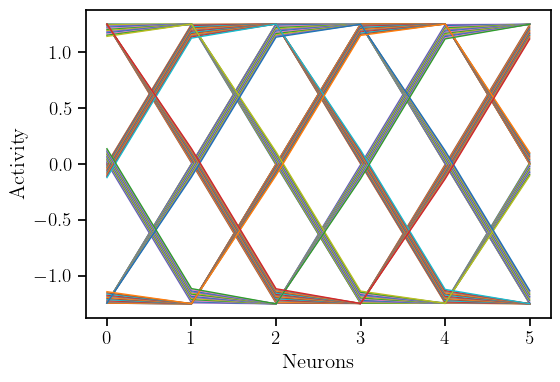

In [1344]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        ax.plot(epssols[bump_i,support_j,-1,:])
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

In [1345]:
speed = np.linalg.norm(epssols[:,:,:-1,:]-epssols[:,:,1:,:],axis=3)

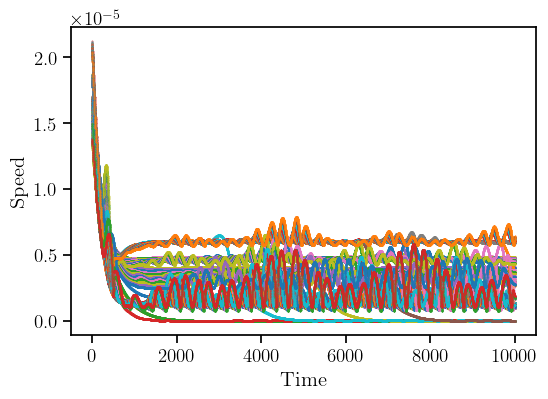

In [1351]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
support_j = 4
for bump_i in range(x.shape[0]):
    for support_j in range(N): #N
            # for t in range(1,100): #epssols.shape[2]
            ax.scatter(range(epssols.shape[2]-1), speed[bump_i,support_j,:], s=.1)
ax.set_ylabel("Speed")
ax.set_xlabel("Time");

### The bump perturbations

In [1368]:
def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    x.shape = (Numberofpoints,N)
    rotation_mat: orientation of perturbation
    implemented for N-dimensional systems
    """
    N = x.shape[0]
    vector_bump = np.zeros(N)
    vector_bump[0] = 1.
    # rotation_mat = special_ortho_group.rvs(N)
    vector_bump = np.dot(vector_bump, rotation_mat)
    vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump

def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    """
    create ODE for Noorman ring attractor with a local bump perturbation
    center,rotation_mat,amplitude,b are set
    """
    vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
    noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return noor + vector_bump

In [1500]:
rotation_mat = special_ortho_group.rvs(N)
#create a random point along the ring attractor by 
        #choosing a random bump
        #and roll with it
bump_i_p = 6 #np.random.randint(0, 10) 
roll_j_p = np.random.randint(N)
center = np.roll(bumps[:,bump_i_p], roll_j_p).copy()
amplitude = 5.
b = .5

In [1481]:
m = np.max(sols)
x = np.arange(0, m, 0.1)
bumps = np.array([m-x,m*np.ones(x.shape),x,x-m,-m*np.ones(x.shape),-x])
x.shape[0]

13

In [1362]:
maxT = 200
t = np.linspace(0, maxT, 501)
sols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        # print(bump_i, support_j)
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T

In [1505]:
epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        # print(bump_i, support_j)
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T


#### Uniformly sampling in perturbed bump

In [1544]:
n_points = 500
sphere_bump = b*uniform_hypersphere_points(n_points, N)+center

In [1545]:
epssols = np.zeros((n_points, t.shape[0], N))
for p_i in range(n_points):
    y0 = sphere_bump[p_i,:]
    sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
    epssols[p_i,...] = sol.sol(t).T

In [1570]:
left_border = np.max(np.unique(np.round(X_proj2_pertraj[:,-1,:],2), axis=1)[:,-1][np.where(np.unique(np.round(X_proj2_pertraj[:,-1,:],2), axis=1)[:,-1]<0.)])
right_border = np.min(np.unique(np.round(X_proj2_pertraj[:,-1,:],2), axis=1)[:,-1][np.where(np.unique(np.round(X_proj2_pertraj[:,-1,:],2), axis=1)[:,-1]>0.)])

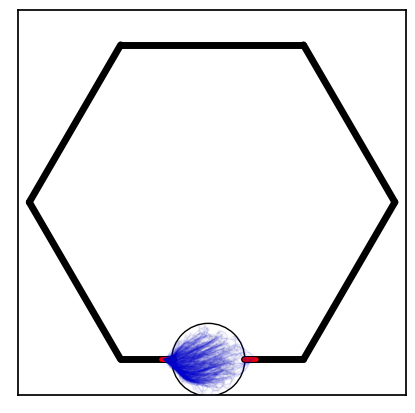

In [1571]:
sols = sols.reshape((-1,t.shape[0], N))
epssols_flat = epssols.reshape((-1,t.shape[0], N))
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:])
X_proj2_pertraj = pca.transform(epssols_flat.reshape((-1, N))).reshape((-1,t.shape[0], 2))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
for i in range(N):
    if (i-1)%N != roll_j_p:
        ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'k', label="Original attractor", zorder=0, alpha=1., linewidth=5, 
            solid_capstyle='round')
        
ax.plot([corners_proj2[(roll_j_p+1)%N,0], right_border],
    [corners_proj2[(roll_j_p+1)%N,1], corners_proj2[(roll_j_p+1)%N,1]],
    'k', label="Original attractor", zorder=0, alpha=1., linewidth=5, 
    solid_capstyle='round')

ax.plot([corners_proj2[(roll_j_p)%N,0], left_border],
    [corners_proj2[(roll_j_p+1)%N,1], corners_proj2[(roll_j_p+1)%N,1]],
    'k', label="Original attractor", zorder=0, alpha=1., linewidth=5, 
    solid_capstyle='round')
    
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.r', label="Stable", zorder=10, alpha=.99, markersize=4)
ax.set(xlim=(-2.65, 2.65), ylim=(-2.65,2.65))

for traj_i in range(X_proj2_pertraj.shape[0]):
    traj = X_proj2_pertraj[traj_i]
    if np.all(np.abs(traj[0,:] - traj[-1,:])>.002):
        ax.plot(traj[:,0], traj[:,1], color='mediumblue', label="", alpha=.1, linewidth=1, zorder=99, solid_capstyle='round')

ax.set_xticks([])
ax.set_yticks([])
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
#           fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

center_pca = pca.transform([center])[0]
circle = plt.Circle(center_pca, b, color='k', fill=False)
ax.add_patch(circle)

sphere_bump_pca = pca.transform(sphere_bump)
plt.plot(sphere_bump_pca[:,0], sphere_bump_pca[:,1], '.k', alpha=.01)

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert.png", bbox_inches="tight")

[(-2.3019794646598744, 2.1980205353401256),
 (-4.4184920428237575, 0.08150795717624248)]

<Figure size 500x500 with 0 Axes>

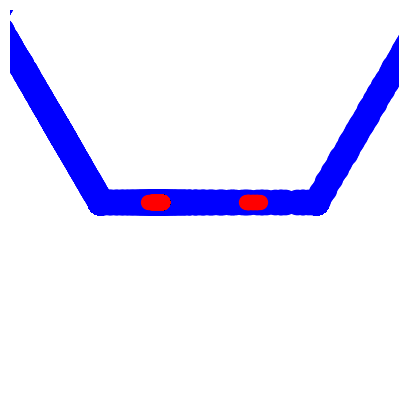

In [1547]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=35)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
center_pca = pca.transform([center])[0]
ax.set(xlim=(center_pca[0]-4.5*b, center_pca[0]+4.5*b), ylim=(center_pca[1]-4.5*b, center_pca[1]+4.5*b))

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.png", bbox_inches="tight")

In [ ]:
t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b

In [1589]:
def noorman_speed(x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    f_x = noorman_ode(0,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return np.linalg.norm(f_x)

def noorman_bump_speed(x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    f_x = noorman_ode_pert(0,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b)
    return np.linalg.norm(f_x)

## Find fixed points through minimization of speed

### BUMP

In [1595]:
n_points = 500
sphere_bump = b*uniform_hypersphere_points(n_points, N)+center

In [1599]:
Nsamples_per_side = x.shape[0]
fxd_points = np.zeros((n_points,N))
speeds = np.zeros((n_points))
for p_i in range(n_points):
    x0 = sphere_bump[p_i,:]
    res = minimize(noorman_bump_speed, x0, method='Nelder-Mead', tol=5e-6, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]))
    fxd_points[p_i,:] = res.x
    speeds[p_i] = res.fun

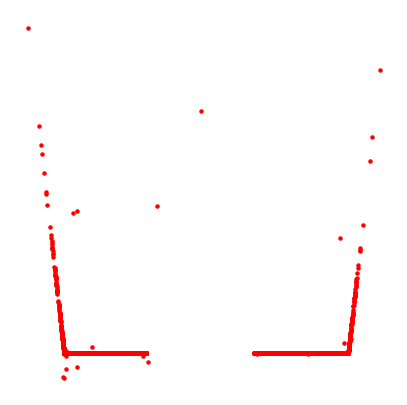

In [1600]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
u_fxd_points = np.unique(np.round(fxd_points, 6), axis=0)
u_fxd_points_proj2 = pca.transform(u_fxd_points) 
plt.scatter(u_fxd_points_proj2[:,0], u_fxd_points_proj2[:,1], color='r', label="Stable", zorder=10, alpha=1., s=5)
ax.set_axis_off();

In [ ]:
plt.hist(speeds, bins=[1e-13, 1e-12, 1e-11, 1e-10]);
plt.xlabel("Speed")

In [ ]:
# noorman_jacobian for bump pert??????
# for i in range(u_fxd_points.shape[0]):
#     eigenvalues, eigenvectors = scipy.linalg.eig(noorman_jacobian(u_fxd_points[i,:], W_sym+eps))
#     plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))

### Connection matrix

In [1601]:
# Nsamples = 10000
# fxd_points = np.zeros((Nsamples,N))
# for i in range(Nsamples):
#     x0 = np.random.uniform(-1,1,N)
#     res = minimize(noorman_speed, x0, method='Nelder-Mead', tol=1e-9, args=(tau,transfer_function,W_sym+eps,W_asym,c_ff,N))
#     fxd_points[i,:] = res.x
    
eps = np.zeros((N,N))
eps[0,1] = 1/100.

Nsamples_per_side = x.shape[0]
fxd_points = np.zeros((Nsamples_per_side*N,N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        x0 = np.roll(bumps[:,bump_i], support_j) 
        res = minimize(noorman_ode, x0, method='SLSQP', tol=5e-10, args=(tau,transfer_function,W_sym+eps,W_asym,c_ff,N))
        fxd_points[bump_i+Nsamples_per_side*support_j,:] = res.x

TypeError: noorman_ode() missing 1 required positional argument: 'N'

[]

<Figure size 500x500 with 0 Axes>

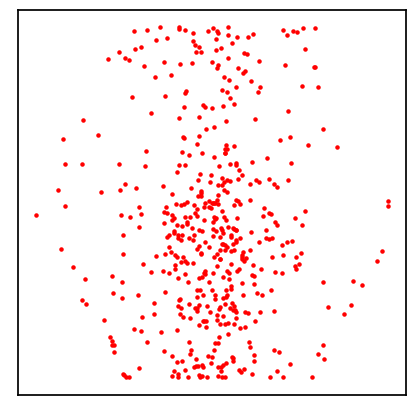

In [1582]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
u_fxd_points = np.unique(np.round(fxd_points, 6), axis=0)
u_fxd_points_proj2 = pca.transform(u_fxd_points) 
plt.scatter(u_fxd_points_proj2[:,0], u_fxd_points_proj2[:,1], color='r', zorder=10, alpha=1., s=5)
ax.set_xticks([])
ax.set_yticks([])

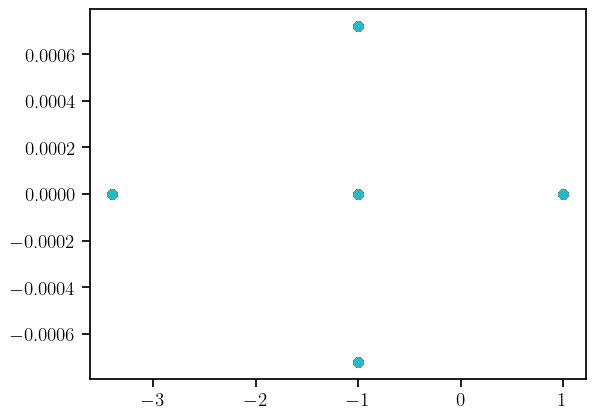

In [1581]:
for i in range(u_fxd_points.shape[0]):
    eigenvalues, eigenvectors = scipy.linalg.eig(noorman_jacobian(u_fxd_points[i,:], W_sym+eps))
    plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))